# TCC - Helder Rezende

# Apresentação TCC

In [1]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas.io.data as web
import seaborn as sns
import statsmodels.api as sm
import arch 
plt.style.use('ggplot')

%matplotlib inline

/home/helder/anaconda2/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


## Pegando a cotação da Ibovespa de 2012 até a data atual

In [2]:
cotacoes = web.DataReader('^BVSP', data_source='yahoo', start='1/1/2000')['Close']

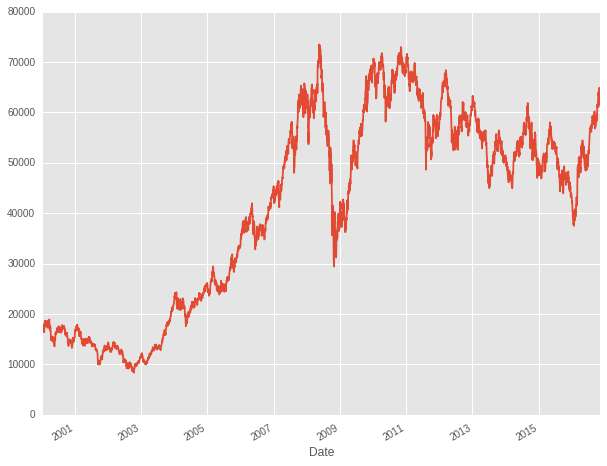

In [3]:
cotacoes[5:].plot(figsize = (10,8))
plt.savefig('cotacao_bovespa.png',bbox_inches='tight')

## Calculando os Retornos

In [4]:
retornos = (cotacoes / cotacoes.shift(1) -1)

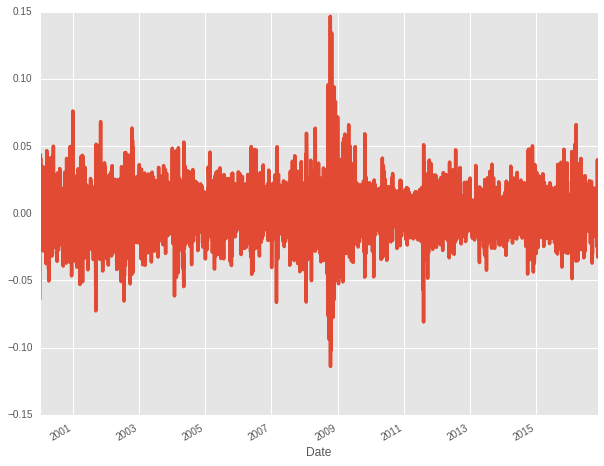

In [5]:
retornos.plot(figsize = (10,8),linewidth=3.5)

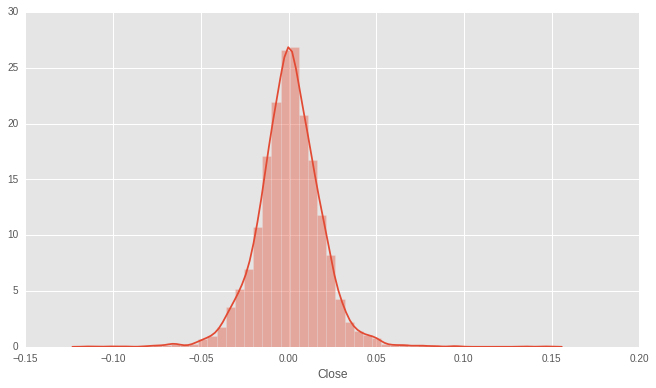

In [6]:
f, ax = plt.subplots(figsize=(11, 6))
sns.distplot(retornos.dropna())
plt.savefig('retornos_ambev.png',bbox_inches='tight')

## Calculando, por fim, a volalitidade ao longo do tempo.

In [7]:
volatilidade_valores = []
#retornos = pd.DataFrame(retornos)


In [8]:
volatilidade_valores = pd.rolling_std(retornos,30)*100*sqrt(252)
#for x in range(len(retornos)):
#    volatilidade_valores.append(pd.rolling_std(retornos[:x],30)*100*sqrt(252))


/home/helder/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).std()
  if __name__ == '__main__':


In [9]:
volatilidade = pd.DataFrame(volatilidade_valores, index = retornos.index,columns = ["Index IBOVESPA"])

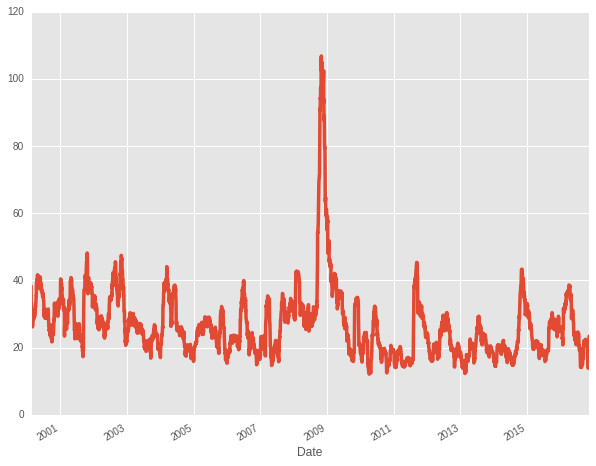

In [10]:
volatilidade_valores[30:].plot(figsize = (10,8),linewidth=3.5)
plt.savefig('volatilidade_bovespa.png',bbox_inches='tight')

## TCC

### Using Extreme Value Theory and Copulas to Evaluate Market Risk



This example shows how to model the market risk of a hypothetical global equity index portfolio with a Monte Carlo simulation technique using a Student's t copula and Extreme Value Theory (EVT). The process first extracts the filtered residuals from each return series with an asymmetric GARCH model, then constructs the sample marginal cumulative distribution function (CDF) of each asset using a Gaussian kernel estimate for the interior and a generalized Pareto distribution (GPD) estimate for the upper and lower tails. A Student's t copula is then fit to the data and used to induce correlation between the simulated residuals of each asset. Finally, the simulation assesses the Value-at-Risk (VaR) of the hypothetical global equity portfolio over a one month horizon.

Note that this is a relatively advanced, comprehensive example that assumes some familiarity with EVT and copulas. For details regarding estimation of generalized Pareto distributions and copula simulation, see the Modelling Tail Data with the Generalized Pareto Distribution and Simulating Dependent Random Variables Using Copulas in the Statistics and Machine Learning Toolbox™. For details regarding the approach upon which most of this example is based, see references [5] and [6] by Nystrom and Skoglund in the bibliography.


In [11]:
iniditalDate = "1/1/2014"
ativos = ['ABEV3', 'PETR4','RADL3','BBDC4']

In [12]:
cotacoesAmbev = web.DataReader('ABEV3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesPetr = web.DataReader('PETR4.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesRadl = web.DataReader('RADL3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesBbdc = web.DataReader('BBDC4.SA', data_source='yahoo', start=iniditalDate)['Close']


In [13]:
cotacoes = [cotacoesAmbev,cotacoesPetr,cotacoesRadl,cotacoesBbdc]
cotacoesPandas = pd.DataFrame(index = ativos, data = cotacoes)


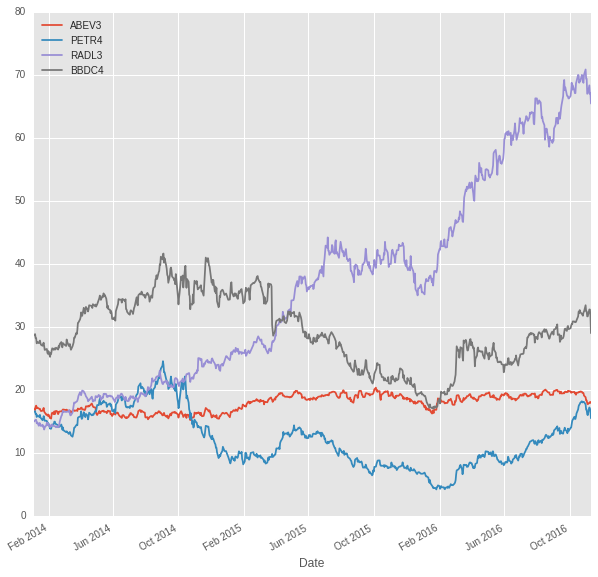

In [14]:
cotacoesPandas.transpose().dropna().plot(figsize= (10,10))

In preparation for subsequent modeling, convert the closing level of each index to daily logarithmic returns (sometimes called geometric, or continuously compounded, returns).

In [15]:
def logReturn(cotacoes):
    return np.log((cotacoes / cotacoes.shift(1)))[1:]

Since the first step in the overall modeling approach involves a repeated application of GARCH filtration and Extreme Value Theory to characterize the distribution of each individual equity index return series, it is helpful to examine the details for a particular country. You can change the next line of code to any integer in the set {1,2,3,4,5,6} to examine the details for any index.

In [16]:
returns = [logReturn(cotacoes[x]) for x in range(len(cotacoes))]
returnsPandas = pd.DataFrame(index = ativos, data = returns)
returnsPandas = returnsPandas.transpose().dropna()

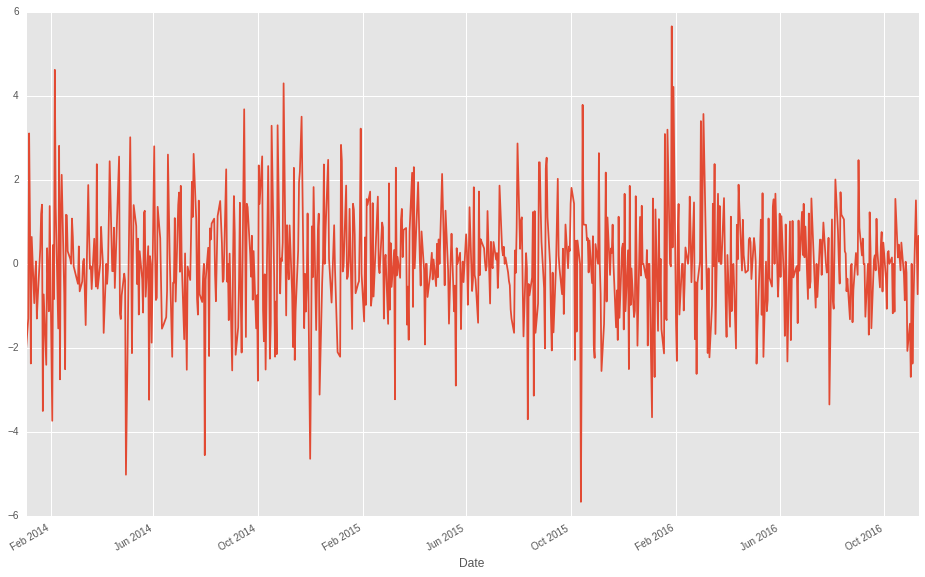

In [41]:
(returnsPandas["ABEV3"]*100).plot(figsize=(16,10))

## Filter the Returns for Each Index

Fonte de estudo para essa parte: https://www.otexts.org/fpp/8/3
https://pypi.python.org/pypi/arch/3.0#bootstrap

Modeling the tails of a distribution with a GPD requires the observations to be approximately independent and identically distributed (i.i.d.). However, most financial return series exhibit some degree of autocorrelation and, more importantly, heteroskedasticity.

For example, the sample autocorrelation function (ACF) of the returns associated with the selected index reveal some mild serial correlation.

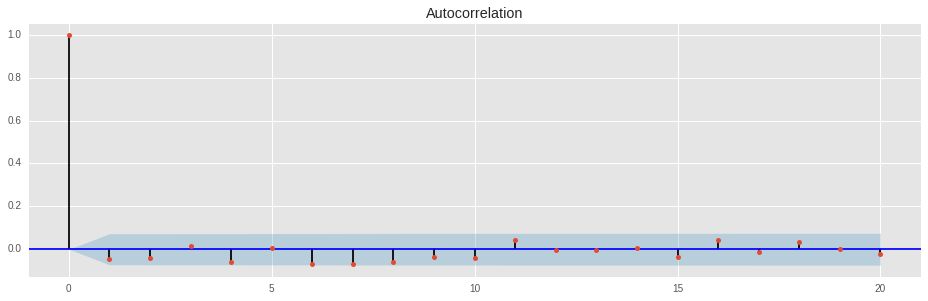

In [18]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ABEV3"], lags=20, ax=ax1)

However, the sample ACF of the squared returns illustrates the degree of persistence in variance, and implies that GARCH modeling may significantly condition the data used in the subsequent tail estimation process.

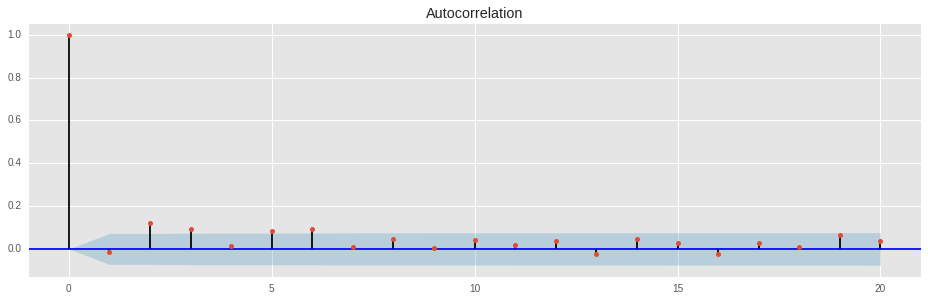

In [19]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ABEV3"]**2, lags=20, ax=ax1)

To produce a series of i.i.d. observations, fit a first order autoregressive model to the conditional mean of the returns of each equity index

$$r_t = c + \theta r_{t-1} + \epsilon_t$$

and an asymmetric GARCH model to the conditional variance

$$\sigma^2_t = \kappa + \alpha\sigma^2_{t-1} + \phi\epsilon^2_{t-1} + \psi[\epsilon_{t-1}<0]\epsilon^2_{t-1}$$

The first order autoregressive model compensates for autocorrelation, while the GARCH model compensates for heteroskedasticity. In particular, the last term incorporates asymmetry (leverage) into the variance by a Boolean indicator that takes the value 1 if the prior model residual is negative and 0 otherwise (see Glosten, Jagannathan, & Runkle [3]).

Additionally, the standardized residuals of each index are modeled as a standardized Student's t distribution to compensate for the fat tails often associated with equity returns. That is

$$z_t = \epsilon_t/\sigma_t$$ i.i.d. distributed $$t(\nu)$$

The following code segment extracts the filtered residuals and conditional variances from the returns of each equity index.

Pacote python utilizado http://arch.readthedocs.io/en/latest/univariate/introduction.html

In [32]:
am = arch.arch_model(returnsPandas["ABEV3"]*100, mean='AR', vol='GARCH', dist = 'StudentsT' )
res = am.fit()


Iteration:      1,   Func. Count:      7,   Neg. LLF: 1236.06417152
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1236.00267489
Iteration:      3,   Func. Count:     29,   Neg. LLF: 1235.99457344
Iteration:      4,   Func. Count:     37,   Neg. LLF: 1235.92355692
Iteration:      5,   Func. Count:     45,   Neg. LLF: 1235.69721144
Iteration:      6,   Func. Count:     53,   Neg. LLF: 1235.67660593
Iteration:      7,   Func. Count:     61,   Neg. LLF: 1235.57940627
Iteration:      8,   Func. Count:     68,   Neg. LLF: 1235.50701167
Iteration:      9,   Func. Count:     75,   Neg. LLF: 1235.48611183
Iteration:     10,   Func. Count:     82,   Neg. LLF: 1235.48296894
Iteration:     11,   Func. Count:     89,   Neg. LLF: 1235.4828462
Iteration:     12,   Func. Count:     96,   Neg. LLF: 1235.48283522
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1235.48283522
            Iterations: 12
            Function evaluations: 96
            Grad

In [34]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                        ABEV3   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -1235.48
Distribution:      Standardized Student's t   AIC:                           2480.97
Method:                  Maximum Likelihood   BIC:                           2503.92
                                              No. Observations:                  728
Date:                      Fri, Nov 11 2016   Df Residuals:                      723
Time:                              10:28:28   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0188  4.437e-02      0.423      0.672    [-6.819e-02,  0.106]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          0.0293  2.954e-02      0.993      0.321  [-2.855e-02,8.724e-02]
alpha[1]       0.0469  1.996e-02      2.349  1.880e-02   [7.772e-03,8.600e-02]
beta[1]        0.9383  2.870e-02     32.690 2.137e-234       [  0.882,  0.995]
                                 Distribution                                 
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
nu             6.5506      1.589      4.122  3.764e-05       [  3.435,  9.666]
==============================================================================

Covariance estimator: robust
"""

In [38]:
pd.DataFrame([res.resid,returnsPandas["ABEV3"]*100]).transpose().head(10)

,resid,ABEV3
Date,,
2014-01-03,-2.169591,-2.150821
2014-01-06,-1.319322,-1.300551
2014-01-07,3.086948,3.105718
2014-01-08,0.957497,0.976267
2014-01-09,-2.389728,-2.370958
2014-01-10,0.622878,0.641649
2014-01-13,-0.953444,-0.934674
2014-01-14,-0.312656,-0.293886
2014-01-15,0.040076,0.058846


For the selected index, compare the model residuals and the corresponding conditional standard deviations filtered from the raw returns. The lower graph clearly illustrates the variation in volatility (heteroskedasticity) present in the filtered residuals.

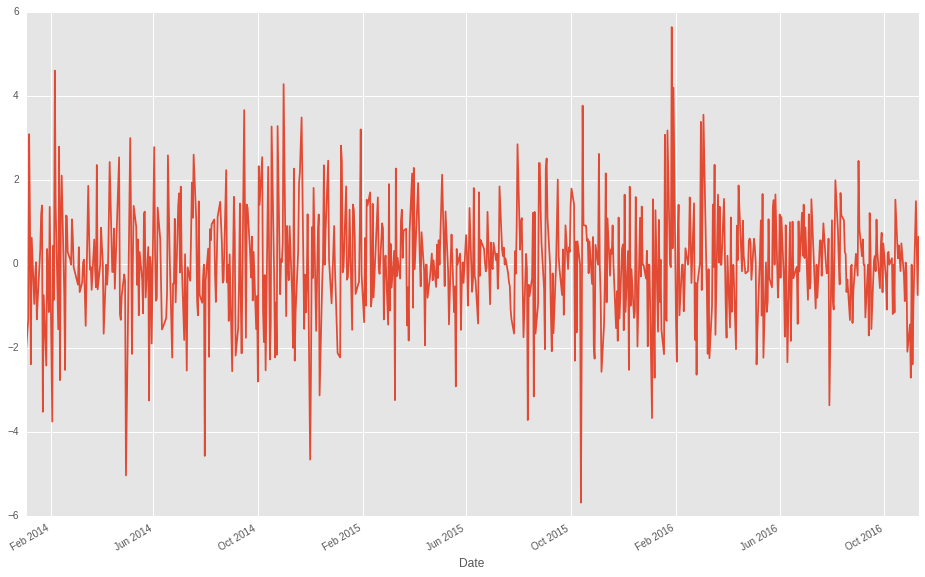

In [42]:
res.resid.plot(figsize=(16,10))

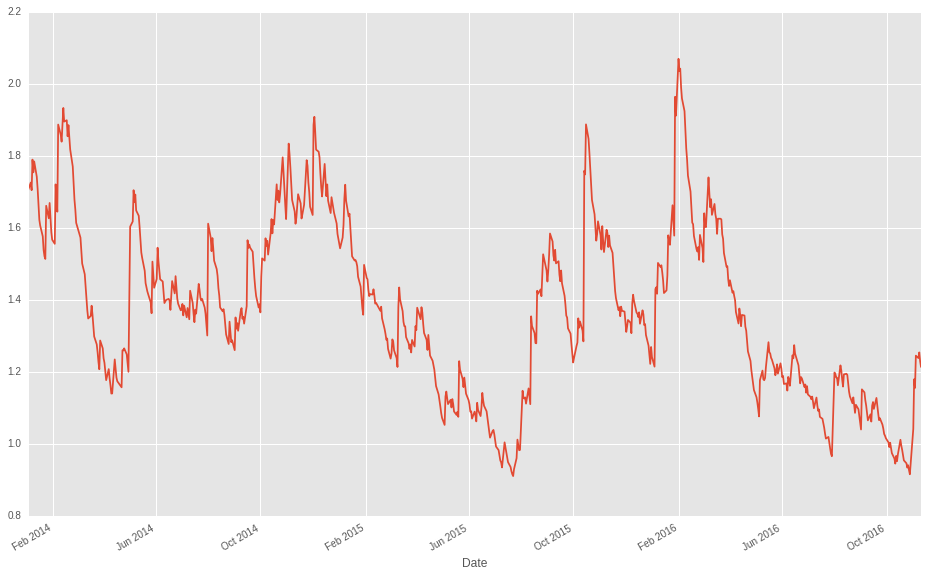

In [44]:
res.conditional_volatility.plot(figsize=(16,10))

Having filtered the model residuals from each return series, standardize the residuals by the corresponding conditional standard deviation. These standardized residuals represent the underlying zero-mean, unit-variance, i.i.d. series upon which the EVT estimation of the sample CDF tails is based.

In [45]:
resid = res.resid/res.conditional_volatility

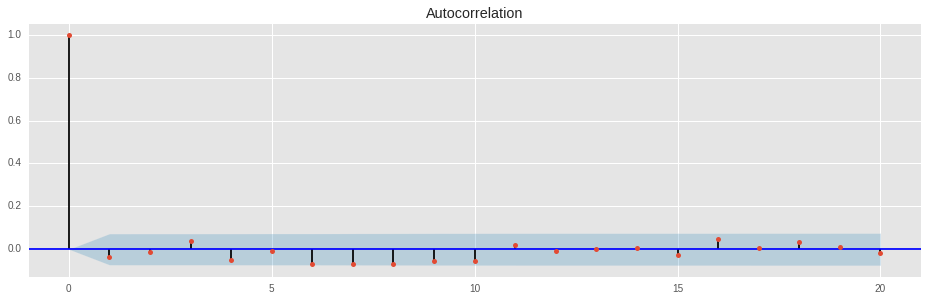

In [49]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax1)

Estimate the Semi-Parametric CDFs

Given the standardized, i.i.d. residuals from the previous step, estimate the empirical CDF of each index with a Gaussian kernel. This smoothes the CDF estimates, eliminating the staircase pattern of unsmoothed sample CDFs. Although non-parametric kernel CDF estimates are well suited for the interior of the distribution where most of the data is found, they tend to perform poorly when applied to the upper and lower tails. To better estimate the tails of the distribution, apply EVT to those residuals that fall in each tail.

Specifically, find upper and lower thresholds such that 10% of the residuals is reserved for each tail. Then fit the amount by which those extreme residuals in each tail fall beyond the associated threshold to a parametric GPD by maximum likelihood. This approach is often referred to as the distribution of exceedances or peaks over threshold method.

Given the exceedances in each tail, optimize the negative log-likelihood function to estimate the tail index (zeta) and scale (beta) parameters of the GPD.

The following code segment creates objects of type paretotails, one such object for each index return series. These paretotails objects encapsulate the estimates of the parametric GP lower tail, the non-parametric kernel-smoothed interior, and the parametric GP upper tail to construct a composite semi-parametric CDF for each index.

The resulting piecewise distribution object allows interpolation within the interior of the CDF and extrapolation (function evaluation) in each tail. Extrapolation is very desirable, allowing estimation of quantiles outside the historical record, and is invaluable for risk management applications.

Moreover, Pareto tail objects also provide methods to evaluate the CDF and inverse CDF (quantile function), and to query the cumulative probabilities and quantiles of the boundaries between each segment of the piecewise distribution.

In [ ]:
nPoints      = 200   
tailFraction = 0.1